# Machine Translation: The phrase-based approach and decoding

In this notebook we'll be looking at the phrase-based SMT.

In [1]:
from collections import defaultdict, Counter
import itertools
from nltk.tokenize import word_tokenize
from nltk.translate import *
from math import log

### Preliminaries

Our problem is to model *Centauri-Arctuan* translation, given no knowledge of these alien languages (ok, they're made up.) The first component of the dataset is short  bitext:

In [2]:
d = """ok-voon ororok sprok .             |||  at-voon bichat dat .
ok-drubel ok-voon anok plok sprok .          |||  at-drubel at-voon pippat rrat dat .
erok sprok izok hihok ghirok .               |||  totat dat arrat vat hilat .
ok-voon anok drok brok jok .                 |||  at-voon krat pippat sat lat .
wiwok farok izok stok .                      |||  totat jjat quat cat .
lalok sprok izok jok stok .                  |||  wat dat krat quat cat .
lalok farok ororok lalok sprok izok enemok . |||  wat jjat bichat wat dat vat eneat .
lalok brok anok plok nok .                   |||  iat lat pippat rrat nnat .
wiwok nok izok kantok ok-yurp .              |||  totat nnat quat oloat at-yurp .
lalok mok nok yorok ghirok clok .            |||  wat nnat gat mat bat hilat .
lalok nok crrrok hihok yorok zanzanok .      |||  wat nnat arrat mat zanzanat .
lalok rarok nok izok hihok mok .             |||  wat nnat forat arrat vat gat ."""

bitext = []
for line in d.split('\n'):
    en, fr = line.split('|||')
    bitext.append(AlignedSent(word_tokenize(en), word_tokenize(fr)))

And a monolingual *Centauri* (called E herein) text:

In [3]:
d = """ok-drubel anok ghirok farok . wiwok rarok nok zerok ghirok enemok .
ok-drubel ziplok stok vok erok enemok kantok ok-yurp zinok jok yorok clok .
lalok clok izok vok ok-drubel . 
ok-voon ororok sprok . 
ok-drubel ok-voon anok plok sprok . 
erok sprok izok hihok ghirok . 
ok-voon anok drok brok jok . 
wiwok farok izok stok . 
lalok sprok izok jok stok . 
lalok brok anok plok nok . 
lalok farok ororok lalok sprok izok enemok . 
wiwok nok izok kantok ok-yurp . 
lalok mok nok yorok ghirok clok . 
lalok nok crrrok hihok yorok zanzanok . 
lalok rarok nok izok hihok mok . """
monolingual = word_tokenize(d)

And some test sentences in *Arctuan* (called F herein):

In [4]:
d = """iat lat pippat eneat hilat oloat at-yurp .
totat nnat forat arrat mat bat .
wat dat quat cat uskrat at-drubel ."""
test = [ word_tokenize(sent) for sent in d.split("\n")]
test

[['iat', 'lat', 'pippat', 'eneat', 'hilat', 'oloat', 'at-yurp', '.'],
 ['totat', 'nnat', 'forat', 'arrat', 'mat', 'bat', '.'],
 ['wat', 'dat', 'quat', 'cat', 'uskrat', 'at-drubel', '.']]

Now we'll obtain some word alignments using IBM model 3:

In [5]:
m = IBMModel3(bitext, 5)
# show the translations of one of the words
m.translation_table['sprok']

defaultdict(<function nltk.translate.ibm_model.<lambda>>,
            {None: 2.4549317962112147e-09,
             '.': 4.700398025663745e-10,
             'arrat': 9.730875743986166e-10,
             'at-drubel': 6.487252144146402e-10,
             'at-voon': 2.2928996232397085e-10,
             'bichat': 2.461320250665924e-10,
             'cat': 4.865439399167633e-10,
             'dat': 0.9999999948024947,
             'eneat': 4.531193844994274e-10,
             'hilat': 1.4596313622543465e-09,
             'jjat': 2.2655969222525066e-10,
             'krat': 4.865439473661642e-10,
             'pippat': 2.1624174032085257e-10,
             'quat': 3.2436262664067507e-10,
             'rrat': 3.243626072073094e-10,
             'totat': 9.730875743553228e-10,
             'vat': 1.1241273694343646e-09,
             'wat': 3.126217439229138e-10})

Let's see what it learned (also try some other sentences, other than just sentence pair 2)

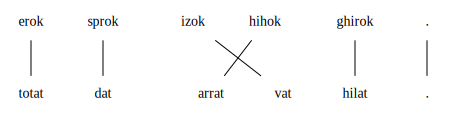

In [6]:
s = bitext[2]
s

If you see the warning message *Cannot find the dot binary from Graphviz package* you might want to install [Graphviz](http://www.graphviz.org/Download.php). Alternatively, you can view the aligned sentences in text using print:

In [10]:
print `s`

AlignedSent(['erok', 'sprok', 'izok', 'hihok', 'ghirok', '.'], ['totat', 'dat', 'arrat', 'vat', 'hilat', '.'], Alignment([(0, 0), (1, 1), (2, 3), (3, 2), (4, 4), (5, 5)]))


We could also align in the reverse direction, and combine the alignments. But for the purpose of this notebook, we won't bother with this improvement. 

### Extracting phrases

The next step in building a phrase-based system is to extract the phrases that are consistent with the alignment, in order to construct the phrase-table. Let's look at the phrases we can obtain from this sentence.

In [7]:
from nltk.translate.phrase_based import phrase_extraction
phrase_extraction(' '.join(s.words), ' '.join(s.mots), s.alignment, max_phrase_length=3)

{((0, 1), (0, 1), 'erok', 'totat'),
 ((0, 2), (0, 2), 'erok sprok', 'totat dat'),
 ((1, 2), (1, 2), 'sprok', 'dat'),
 ((1, 4), (1, 4), 'sprok izok hihok', 'dat arrat vat'),
 ((2, 3), (3, 4), 'izok', 'vat'),
 ((2, 4), (2, 4), 'izok hihok', 'arrat vat'),
 ((2, 5), (2, 5), 'izok hihok ghirok', 'arrat vat hilat'),
 ((3, 4), (2, 3), 'hihok', 'arrat'),
 ((4, 5), (4, 5), 'ghirok', 'hilat'),
 ((4, 6), (4, 6), 'ghirok .', 'hilat .'),
 ((5, 6), (5, 6), '.', '.')}

Note that this only a small subset of the possible spans over the two sentences. Some are some spans that aren't valid, such as *sprok izok* (1,3). Can you explain why?

### Building the phrase table

To build the full phrase-table we will extract all phrase-pairs (as above) and store their counts. Finally we normalise to give a conditional probability of $p(f|e)$ (roughly speaking.)

In [8]:
phrase_pair_counts = defaultdict(Counter)
for s in bitext:
    phrases = phrase_extraction(' '.join(s.words), ' '.join(s.mots), s.alignment, max_phrase_length=3)
    for en_span, fr_span, en_phrase, fr_phrase in phrases:
        phrase_pair_counts[tuple(en_phrase.split())][tuple(fr_phrase.split())] += 1
#phrase_table

And then normalise their counts to form conditional probabilities, such that they sum to one. We also take the logarithm, because the decoder sums log probabilities rather than multiplies probabilities (to avoid *floating point underflow*).

In [9]:
phrase_table = PhraseTable()
for en_phrase, fr_counts in phrase_pair_counts.items():
    total = sum(fr_counts.values())
    for fr_phrase, count in fr_counts.items():
        phrase_table.add(fr_phrase, en_phrase, log(count / float(total)))

You should inspect the learned values, and you'll see that most probabilities are 1 (i.e., 0 in log space.) Can you explain why this is the case?

### Building a language model

The next step is to build a language model. We'll use a simple unigram model, with no smoothing. Of course in practice you'd use a higher order model, usually between 3-5 grams and with fancy smoothing such as modified Kneser-Ney.

In [12]:
# count the words
unigram_counts = Counter()
for token in monolingual:
    unigram_counts[token] += 1
    
# normalise and take logarithm
language_prob = defaultdict(lambda: -999.0)
total_words = sum(unigram_counts.values())
for word_type, count in unigram_counts.items():
    language_prob[word_type] = log(count / float(total_words))
#language_prob

For the purposes of the *StackDecoder* in NLTK, we need to wrap the LM using an object with methods to score the LM probabilities wholly within a phrase for future cost estimation (*probability*) and in context for use when adding nodes to the decoding graph (*probability_change*). 

In [13]:
class LM:
    def __init__(self, probs):
        self.probs = probs        
    def probability_change(self, context, phrase): 
        # Used when expanding a hypothesis with a new phrase
        # (higher order LMs would need to look at the word sequence, including context)
        return sum([self.probs[word] for word in phrase])
    def probability(self, phrase): 
        # Used for future cost estimation only, to get a cheap (approximate) LM score for each phrase 
        return sum([self.probs[word] for word in phrase])
language_model = LM(language_prob)

### Putting it all together

Now let's create the decoder with our phrase-table and LM, and ask it to translate a sentence:

In [14]:
stack_decoder = StackDecoder(phrase_table, language_model)
stack_decoder.translate(test[0])

['lalok', 'brok', 'anok', 'enemok', 'ghirok', 'kantok', 'ok-yurp', '.']

Try out some of the other test sentences. Does it always succeed in translating all of them? (What might might cause it to fail?) And are the translations any good - with a unigram LM, there's no incentive to reorder the words, which could be detrimental... You might want to try moving to a bigram LM.

To improve on this, you will need to delve deeper into the code of the phrase-based stack decoder. Please refer to [the nltk.translate API documentation and source code](http://www.nltk.org/_modules/nltk/translate/stack_decoder.html). Note that this is only a toy implementation, which is great for learning purposes, although for realistic settings tools like [the moses open source decoder](http://www.statmt.org/moses/) are more suitable. You can see how the phrase-based model can be used in moses in the [moses tutorial](http://www.statmt.org/moses/?n=Moses.Tutorial).

If you're curious about the data, please see the excellent [article by Kevin Knight about learning translation models using EM](http://www.ai.mit.edu/courses/6.891-nlp/READINGS/aimag97.pdf) where it forms the running example. (Yes, it's not really alien language, but it is based on actual human languages.)